In [40]:
import numpy as np
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

In [57]:
# An implementation of tabular minimax-Q learning

def get_greedy(Q, state, action_set, player):
    valid_vals = Q[state, action_set]
    opt_val = None
    if player == 0:
        opt_val = np.max(valid_vals)
    else:
        opt_val = np.min(valid_vals)
    opt_acts = np.where(valid_vals == opt_val)[0]
    ind = np.random.randint(len(opt_acts))
    return action_set[opt_acts[ind]]

def get_epsilon_greedy(Q, state, epsilon, action_set, player):
    if epsilon < np.random.rand():
        ind = np.random.randint(len(action_set))
        return action_set[ind]
    else:
        return get_greedy(Q, state, action_set, player)

# Q-tables are nested dictionaries... Perhaps not the most efficient
class Qtable():
    def __init__(self):
        self.Q = {}
    
    def __getitem__(self, state_actions):
        # No checks performed...
        state, actions = state_actions
        
        if state not in self.Q:
            self.Q[state] = {}
            if type(actions) == list:
                for a in actions:
                    self.Q[state][a] = 0
            else:
                self.Q[state][actions] = 0
        if type(actions) == list:
            rv = []
            for a in actions:
                if a not in self.Q[state]:
                    self.Q[state][a] = 0
                rv.append(self.Q[state][a])
            return rv
        else:
            if actions not in self.Q[state]:
                self.Q[state][actions] = 0
            return self.Q[state][actions]
    
    def __setitem__(self, state_action, value): 
        # No checks performed...
        state, action = state_action
        if state not in self.Q:
            self.Q[state] = {}
        self.Q[state][action] = value

def minimaxQ(env, episodes, alpha, epsilon, discount):
    Q = Qtable()
    
    for ep_n in tqdm(range(episodes)):
        # Reset
        done = False
        state, action_set, player = env.reset()
        while not done:
            # Step
            action = get_epsilon_greedy(Q, state, epsilon, action_set, player)
            nextState, reward, done, next_action_set, nextPlayer = env.step(action)
            # Update
            delta = 0
            if done:
                delta = reward - Q[state, action]
            else:
                greedy_action = get_greedy(Q, nextState, next_action_set, nextPlayer)
                delta = reward + discount*Q[nextState, greedy_action] - Q[state, action]
            Q[state, action] = Q[state, action] + alpha*delta
            
            # Shift
            state = nextState
            player = nextPlayer
            action_set = next_action_set
        #if ep_n%10000==0:    
        #    path_str = "C:\\Users\\Admin\\PycharmProjects\\python-ppo\\Gridworld\\saved-models\\episode{}.".format(ep_n)    
        #    np.save(path_str, Q)    

    return Q

In [58]:
# A simple environment:
# Two agents on a 4 x 3 grid world. Their goal is to swap places 
# while staying on the left side of the arena from their perspective.
# Each column is labeled "A" "B" "C" from left to right.
# Movement is deterministic. States are numbered from left to right, top down.

# The grid:
# 0 | 1  | 2
# 3 | 4  | 5
# 6 | 7  | 8
# 9 | 10 | 11
# 
# Agent 1 starts in 10
# Agent 2 starts in 1

# A = {0,3,6,9} # Avoid for agent 2
# B = {4,7} 
# C = {2,5,8,11} # Avoid for agent 1
# D = {1} # Goal for agent 1; agent 2 avoids after first timestep
# E = {10} # Goal for agent 2; agent 1 avoids after first timestep
# F = agents collided # Avoid for agents 1 and 2

# Automaton for agent 1
class Automaton1():
    def __init__(self):
        pass
    
    def reset(self):
        self.q = 0
        return self.q, False # State, isAccepting
    
    def step(self, label):
        if self.q == 0:
            if label == 'C' or label == 'F': # Go to trap
                self.q = 3
            elif label == 'D': # Accept
                self.q = 2
            else:
                self.q = 1
        elif self.q == 1:
            if label == 'C' or label == 'F' or label == 'E':
                self.q = 3
            elif label == 'D':
                self.q = 2
        elif self.q == 2:
            if label == 'C' or label == 'F' or label == 'E':
                self.q = 3
        return self.q, self.q == 2

# Automaton for agent 2
class Automaton2():
    def __init__(self):
        pass
    
    def reset(self):
        self.q = 0
        return self.q, False # State, isAccepting
    
    def step(self, label):
        if self.q == 0:
            if label == 'A' or label == 'F': # Go to trap
                self.q = 3
            elif label == 'E': # Accept
                self.q = 2
            else:
                self.q = 1
        elif self.q == 1:
            if label == 'A' or label == 'F' or label == 'D':
                self.q = 3
            elif label == 'E':
                self.q = 2
        elif self.q == 2:
            if label == 'A' or label == 'F' or label == 'D':
                self.q = 3
        return self.q, self.q == 2

# Subsystem for agent 1
# Its state is (grid position, has collided)
class Subsystem1():
    def __init__(self):
        pass
    
    def getActionSet(self):
        action_set = []
        if self.s != 0 and self.s != 1 and self.s != 2:
            action_set.append('N')
        if self.s != 0 and self.s != 3 and self.s != 6 and self.s != 9:
            action_set.append('W')
        if self.s != 9 and self.s != 10 and self.s != 11:
            action_set.append('S')
        if self.s != 2 and self.s != 5 and self.s != 8 and self.s != 11:
            action_set.append('E')
        return action_set
    
    def reset(self):
        self.s = 10
        self.collided = False # Collided with other agent
        return (self.s, self.collided), self.getActionSet()
    
    def step(self, action, state_i):
        # I don't check if the action selected is valid in this implementation...
        # The directions are North East South West.
        if action == 'N':
            self.s = self.s - 3
        elif action == 'E':
            self.s = self.s + 1
        elif action == 'S':
            self.s = self.s + 3
        elif action == 'W':
            self.s = self.s - 1
        
        if self.s == state_i[0]:
            self.collided = True
        return (self.s, self.collided), self.getActionSet()   
    
# Subsystem for agent 2
# Its state is (grid position, has collided)
class Subsystem2():
    def __init__(self):
        pass
    
    def getActionSet(self):
        action_set = []
        if self.s != 0 and self.s != 1 and self.s != 2:
            action_set.append('N')
        if self.s != 0 and self.s != 3 and self.s != 6 and self.s != 9:
            action_set.append('W')
        if self.s != 9 and self.s != 10 and self.s != 11:
            action_set.append('S')
        if self.s != 2 and self.s != 5 and self.s != 8 and self.s != 11:
            action_set.append('E')
        return action_set
    
    def reset(self):
        self.s = 1
        self.collided = False # Collided with other agent
        return (self.s, self.collided), self.getActionSet()
    
    def step(self, action, state_i):
        if action == 'N':
            self.s = self.s - 3
        elif action == 'E':
            self.s = self.s + 1
        elif action == 'S':
            self.s = self.s + 3
        elif action == 'W':
            self.s = self.s - 1
        
        if self.s == state_i[0]:
            self.collided = True
        return (self.s, self.collided), self.getActionSet()   

# The environment that sets up the game for agent 1
class Env():
    def __init__(self):
        self.automaton1 = Automaton1()
        self.automaton2 = Automaton2()
        self.subsystem1 = Subsystem1()
        self.T = 6 # Horizon
        
    def getLabel(self, state):
        if state[1]:
            return 'F'
        x = state[0]
        if x % 3 == 0:
            return 'A'
        elif x % 3 == 2:
            return 'C'
        elif x == 1:
            return 'D'
        elif x == 10:
            return 'E'
        else:
            return 'B'
    
    def getStates(self, label):
        if label == 'F':
            return [(x,True) for x in range(12)]
        if label == 'A':
            return [(0,False),(3,False),(6,False),(9,False)]
        elif label == 'B':
            return [(4,False),(7,False)]
        elif label == 'C':
            return [(2,False),(5,False),(8,False),(11,False)]
        elif label == 'D':
            return [(1,False)]
        elif label == 'E':
            return [(10,False)]
    
    def reset(self):
        self.t = 0
        self.player = 0 # 0 for maximizing player, 1 for minimizing
        sub_state, action_set = self.subsystem1.reset()
        auto_state1, _ = self.automaton1.reset()
        auto_state2, _ = self.automaton2.reset()
        label = 'D' # Opponent begins in state 1 labeled D
        self.state = (sub_state, auto_state1, auto_state2, label, self.t)
        return self.state, action_set, self.player
    
    def step(self, action):
        self.player = 1 - self.player
        action_set = None
        acc1 = None
        acc2 = None
        if self.player == 1:
            self.state = self.state + (action,) # Append action to state
            action_set = list(itertools.product(self.getStates(self.state[-3]), ['A','B','C','D','E','F']))
        else:
            min_state = action[0] # Selected state
            next_label = action[1] # Selected label
            self.t = self.t + 1   
            sub_state, action_set = self.subsystem1.step(self.state[-1], min_state)
            auto_state1, acc1 = self.automaton1.step(self.getLabel(sub_state))
            auto_state2, acc2 = self.automaton2.step(self.state[-3])
            self.state = (sub_state, auto_state1, auto_state2, next_label, self.t)
        
        reward = 1 if acc1 else 0 
        
        done = False
        if self.t >= self.T or acc1:
            if not acc2: # Opponent failed their property
                reward = 1
            if reward != 1: # Punish on last step if reward is zero
                reward = -1
            done = True
            
        return self.state, reward, done, action_set, self.player

In [65]:
# Train
env = Env()
episodes = 500001
alpha = 1 # The environment is deterministic
epsilon = 0.2
discount = 1

Q = minimaxQ(env, episodes, alpha, epsilon, discount)

100%|██████████| 500001/500001 [08:25<00:00, 989.57it/s] 


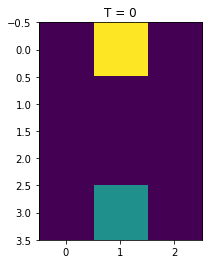

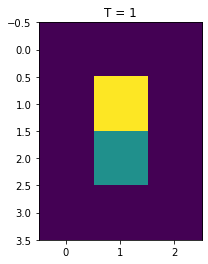

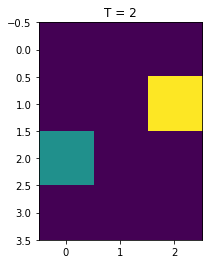

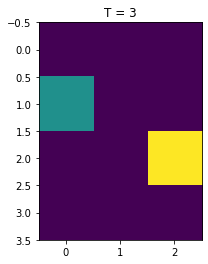

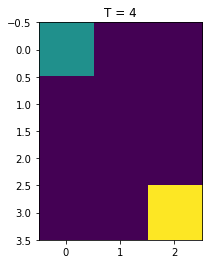

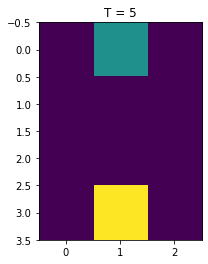

In [64]:
# Simulation
def getLabel(state):
    if state[1]:
        return 'F'
    x = state[0]
    if x % 3 == 0:
        return 'A'
    elif x % 3 == 2:
        return 'C'
    elif x == 1:
        return 'D'
    elif x == 10:
        return 'E'
    else:
        return 'B'
flip = {'N': 'S', 'S': 'N', 'W': 'E', 'E': 'W'} # Pick mirrored action
    
# Reset 
subsystem1 = Subsystem1()
subsystem2 = Subsystem2()
automaton1 = Automaton1()
automaton2 = Automaton2()
state1, action_set1 = subsystem1.reset()
state2, action_set2 = subsystem2.reset()
auto_state1, _ = automaton1.reset()
auto_state2, _ = automaton2.reset()
label1 = getLabel(state1)
label2 = getLabel(state2)

# Steps
for t in range(0,6):
    S = np.zeros((4,3))
    S[state1[0]//3, state1[0]%3] = 1
    S[state2[0]//3, state2[0]%3] = 2
    plt.imshow(S)
    plt.title('T = {:d}'.format(t))
    plt.show()
    
    env_state = (state1, auto_state1, auto_state2, label2, t)
    act1 = get_greedy(Q, env_state, action_set1, 0)
    act2 = flip[act1] # The solution is symmetrical in this problem. For other problems, more work required.
    auto_state1, _ = automaton1.step(getLabel(state1))
    auto_state2, _ = automaton2.step(getLabel(state2))
    state1, action_set1 = subsystem1.step(act1, state2)
    state2, action_set2 = subsystem2.step(act2, state1)
    label1 = getLabel(state1)
    label2 = getLabel(state2)